In [1]:
import torch
import pandas as pd 
import torchvision
from torchvision import datasets, transforms
from torch import nn,optim
import torch.nn.functional as F

## Dataset 

### **Training dataset**

In [2]:
data = pd.read_csv('file:/root/bryan/NG/csv-files/rfe-train.csv')

label = data[["lon_3414","lat_3414"]]
#print(label)

data = data.drop(columns=['type','timestamp','latitude','longitude','lon_3414','lat_3414','floor_id'])
#print(data)

#convert df to tensor object
data = torch.tensor(data.values)

label_t = torch.tensor(label.values)

#flatten 
data_t = torch.flatten(data,1)

label_t = torch.flatten(label_t,1)
print("data shape: " + str(data_t.shape))
print("label shape: " + str(label_t.shape))


train_data = [] 
for i in range(len(data_t)):
    train_data.append([data_t[i],label_t[i]])






data shape: torch.Size([1954, 400])
label shape: torch.Size([1954, 2])


### Validation dataset

In [3]:
data_val = pd.read_csv('file:/root/bryan/NG/csv-files/rfe-test.csv')
label_val=data_val[["lon_3414","lat_3414"]]
data_val=data_val.drop(columns=['type','timestamp','latitude','longitude','lon_3414','lat_3414','floor_id'])
#convert df to tensor object
data_val = torch.tensor(data_val.values)

label_val_t = torch.tensor(label_val.values)

#flatten 
data_val_t = torch.flatten(data_val,1)

label_val_t = torch.flatten(label_val_t,1)
print("data shape: " + str(data_val_t.shape))
print("label shape: " + str(label_val_t.shape))

val_data = [] 
for i in range(len(data_val_t)):
    val_data.append([data_val_t[i],label_val_t[i]])

data shape: torch.Size([697, 400])
label shape: torch.Size([697, 2])


### Put into train/test loader

In [4]:
#put both train and validation sets into loader 
trainloader = torch.utils.data.DataLoader(train_data, batch_size=32)
testloader = torch.utils.data.DataLoader(val_data, batch_size=32)

print("Finish dataset part")

Finish dataset part


## Model 

In [5]:
class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(data_val_t.shape[1],300)
        self.fc2 = nn.Linear(300,300)
        self.fc3 = nn.Linear(300,300)
        self.fc4 = nn.Linear(300,2)

        
        self.dropout = nn.Dropout(p=0.5)
        
    def forward(self,x):
        x = x.view(x.shape[0],-1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.dropout(F.relu(self.fc2(x)))
        x = self.dropout(F.relu(self.fc3(x)))
        x = self.fc4(x)
        
        return x

    


In [6]:
def weight_reset(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()



In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Computation device: {device}\n")
model = Classifier()
model.apply(weight_reset)
model.to(device)

# optimizer = optim.Adam(model.parameters(), lr=0.003, eps = 1e-9) 
optimizer = optim.SGD(model.parameters(), lr = 0.004, weight_decay=0.03, momentum=0.003)

criterion = nn.MSELoss() #MSE
#criterion = torch.nn.L1Loss()

epochs = 500
train_losses, test_losses = [],[]

for e in range(epochs):
    tot_train_loss = 0 
    for data, labels in trainloader:
        data, labels = data.to(device), labels.to(device)
        data = data.view(data.shape[0],-1)
        data = data.float()
        optimizer.zero_grad()
        output = model(data)
        #print(output)
        #output = ((output - torch.mean(output))/torch.max(output)-torch.min(output))
        loss = torch.sqrt(criterion(output,labels.float())) #RMSE 
        #loss = criterion(output,labels.float())
        tot_train_loss+=loss.item()
        
        loss.backward()
        optimizer.step()
        


    else:
        if e>=100 and e%5==0 :
            torch.save(model.state_dict(), './outputs/rfe/rfe-epoch-{}.pth'.format(e))
        tot_test_loss = 0 
        with torch.no_grad():
            for data, labels in testloader:
                data, labels = data.to(device), labels.to(device)
                data = data.view(data.shape[0],-1)
                data=data.float()
                test_output = model(data)
                loss = torch.sqrt(criterion(test_output,labels.float()))
                #loss = criterion(test_output,labels.float())

                tot_test_loss+=loss.item()
                
        train_loss = tot_train_loss/len(trainloader.dataset)
        test_loss = tot_test_loss/len(trainloader.dataset)
        train_losses.append(train_loss)
        test_losses.append(test_loss)

        print("Epoch:{}/{}..".format(e+1,epochs),
             "Training Loss:{:.3f}..".format(train_loss),
             "Test Loss:{:.3f}..".format(test_loss))


Computation device: cuda

Epoch:1/500.. Training Loss:106932.233.. Test Loss:339.841..
Epoch:2/500.. Training Loss:957.993.. Test Loss:340.976..
Epoch:3/500.. Training Loss:957.513.. Test Loss:339.799..
Epoch:4/500.. Training Loss:957.349.. Test Loss:340.231..
Epoch:5/500.. Training Loss:957.236.. Test Loss:339.713..
Epoch:6/500.. Training Loss:956.761.. Test Loss:339.394..
Epoch:7/500.. Training Loss:950.064.. Test Loss:327.872..
Epoch:8/500.. Training Loss:555.521.. Test Loss:143.390..
Epoch:9/500.. Training Loss:366.933.. Test Loss:141.996..
Epoch:10/500.. Training Loss:327.089.. Test Loss:141.335..
Epoch:11/500.. Training Loss:309.797.. Test Loss:122.295..
Epoch:12/500.. Training Loss:313.593.. Test Loss:130.582..
Epoch:13/500.. Training Loss:304.651.. Test Loss:112.133..
Epoch:14/500.. Training Loss:301.617.. Test Loss:114.778..
Epoch:15/500.. Training Loss:300.315.. Test Loss:115.303..
Epoch:16/500.. Training Loss:305.959.. Test Loss:123.993..
Epoch:17/500.. Training Loss:301.458

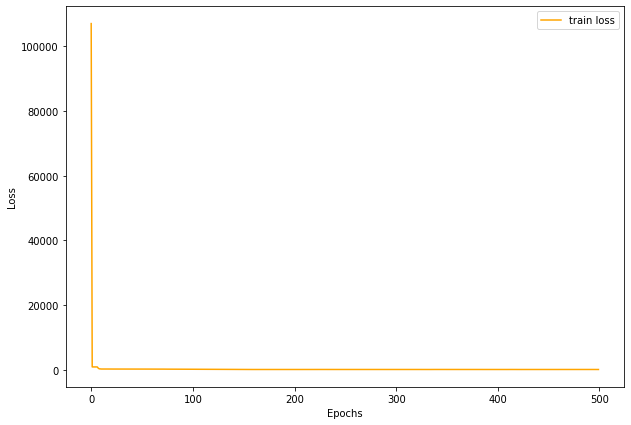

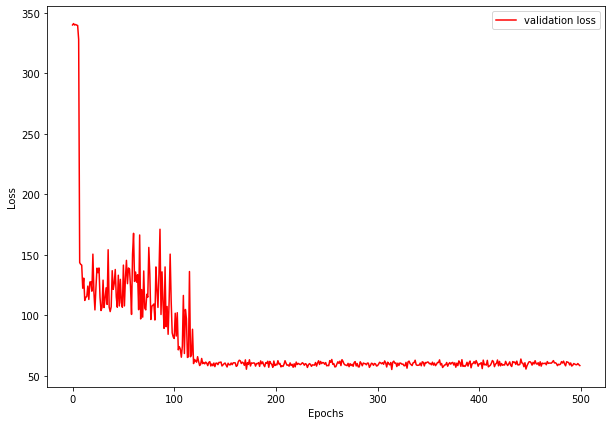

In [8]:
import matplotlib.pyplot as plt


# loss plots
plt.figure(figsize=(10, 7))
plt.plot(train_losses, color='orange', label='train loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"./outputs/{loss_plot_name}.png")
plt.show()

# loss plots
plt.figure(figsize=(10, 7))
plt.plot(test_losses, color='red', label='validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
#plt.savefig(f"./outputs/{loss_plot_name}.png")
plt.show()

In [ ]:
#torch.save(model.state_dict(), f"./outputs/control.pth")


In [ ]:
#print(model.state_dict())

In [9]:
print(min(test_losses))

55.05562483007613
